# Word image generator

This code takes a text as an input and generates the corresponding text in a png image and a separate file with the bounding boxes of each letter

## Imports

In [1]:
import numpy as np
import PIL
import pandas as pd
import matplotlib.pyplot as plt 
import os
import cv2
from random import randint

## Parameters

In [2]:
phrase = "the quick brown fox jumps over the lazy dog"
X_train_folder = "UNet/XTrain/"
Y_train_folder = "UNet/YTrain/"

X_test_folder = "UNet/XTest/"
Y_test_folder = "UNet/YTest/"

repetitions = 1000

## Setup 

In [3]:
testing_letter = pd.read_csv('./archive/emnist-letters-test.csv')
training_letter = pd.read_csv('./archive/emnist-letters-train.csv')

#training_letters
y1 = np.array(training_letter.iloc[:,0].values)
x1 = np.array(training_letter.iloc[:,1:].values)
#testing_labels
y2 = np.array(testing_letter.iloc[:,0].values)
x2 = np.array(testing_letter.iloc[:,1:].values)

Y = np.concatenate((y1,y2))
X = np.concatenate((x1,x2))

#### Plot some of the data

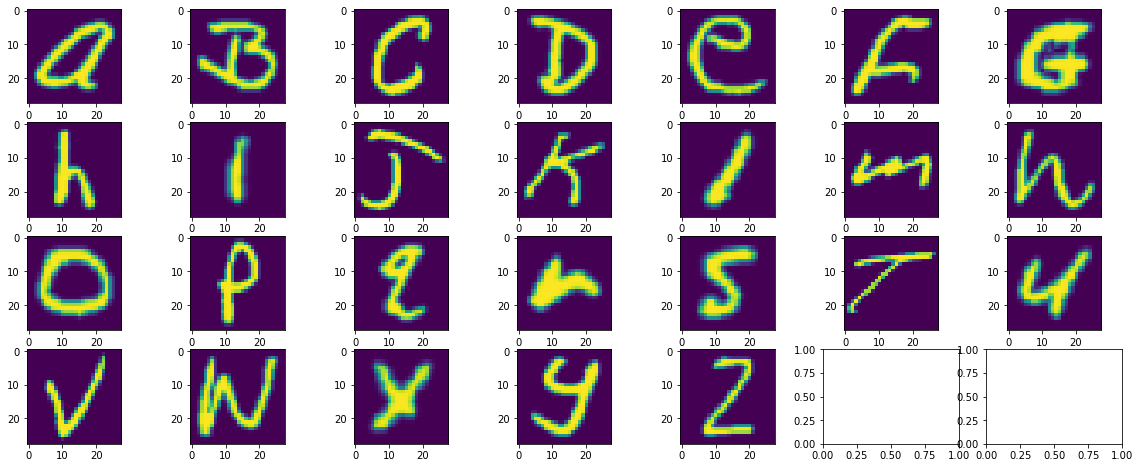

In [4]:
fig,axes = plt.subplots(4,7,figsize=(20,8))
for i,ax in enumerate(axes.flat):
    if i==26:
        break
    pos = np.where(Y==i+1)
    ax.imshow(np.transpose(X[pos[0][0]].reshape([28,28])))


## Building and saving images

In [5]:
def LetterJoiner(BaseWord,Letter):

    overlap = False
    i_orig = BaseWord.shape[1]
    i = 28
    
    while not(overlap):
        #Make the canvas
        auxImg = np.zeros([28,i])
        tmpImg = np.concatenate((BaseWord,auxImg), axis=1)
        
        i_curr = i_orig-(28-i)
        tmpImg[:,i_curr:] = np.add(tmpImg[:,i_curr:],Letter)


        if np.amax(tmpImg)>255.0:
            overlap = True
            break

        i-=1
    mask = np.zeros([28,i_orig+i])
    mask[:,i_curr:] = np.where(Letter != 0, 1, 0)
    
    return tmpImg, mask, i

In [6]:
dictionary = "abcdefghijklmnopqrstuvwxyz"


data_i = 0

words = phrase.split(" ")
for word_i in range(len(words)):
    curr_word = words[word_i]
    curr_rep = 0
    
    while curr_rep<repetitions:
        first = True
        for letter in range(len(curr_word)):
            index = 1 + dictionary.find(curr_word[letter])
            pos = np.where(Y==index)
            rand_ind = randint(0,pos[0].size-1)

            if first:
                pos = np.where(Y==index)
                BaseImg = np.transpose(X[pos[0][rand_ind]].reshape([28,28]))
                LabelImg = np.where(BaseImg != 0, index, 0)
                first = False
                continue

            
            curr_let = np.transpose(X[pos[0][rand_ind]].reshape([28,28]))
            curr_let *= int(255/curr_let.max())
            BaseImg,maskImg, increment  = LetterJoiner(BaseImg,curr_let)
            
            
            LabelImg = np.pad(LabelImg, ((0,0),(0, increment)), mode='constant', constant_values = 0)
            LabelImg[maskImg != 0] = index
            
            BaseImg = np.clip(BaseImg, a_min=None, a_max=255.0)

        cv2.imwrite(X_train_folder+str(data_i)+".png", (255 - BaseImg))
        cv2.imwrite(Y_train_folder+str(data_i)+".png", LabelImg)
        curr_rep +=1
        data_i += 1


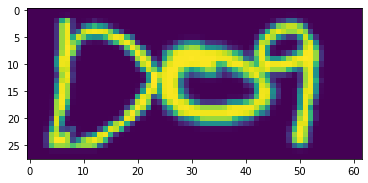

In [7]:
plt.imshow(BaseImg)


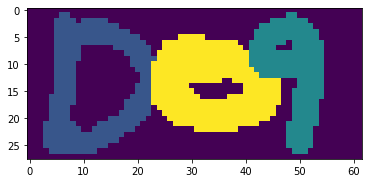

In [8]:
plt.imshow(LabelImg)

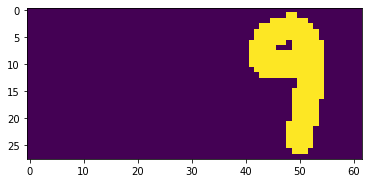

In [9]:
plt.imshow(maskImg)

### Generate Test dataset

In [10]:
data_i = 0
repetitions = 30

for word_i in range(len(words)):
    curr_word = words[word_i]
    curr_rep = 0
    
    while curr_rep<repetitions:
        first = True
        for letter in range(len(curr_word)):
            index = 1 + dictionary.find(curr_word[letter])
            pos = np.where(Y==index)
            rand_ind = randint(0,pos[0].size-1)

            if first:
                pos = np.where(Y==index)
                BaseImg = np.transpose(X[pos[0][rand_ind]].reshape([28,28]))
                LabelImg = np.where(BaseImg != 0, index, 0)
                first = False
                continue

            
            curr_let = np.transpose(X[pos[0][rand_ind]].reshape([28,28]))

            BaseImg,maskImg, increment  = LetterJoiner(BaseImg,curr_let)
            
            
            LabelImg = np.pad(LabelImg, ((0,0),(0, increment)), mode='constant', constant_values = 0)
            LabelImg[maskImg != 0] = index
            
            BaseImg = np.clip(BaseImg, a_min=None, a_max=255.0)

        cv2.imwrite(X_test_folder+str(data_i)+".png", (255 - BaseImg))
        cv2.imwrite(Y_test_folder+str(data_i)+".png", LabelImg)
        curr_rep +=1
        data_i += 1
